## Code#2 Information

**Author:**  Shafagh Keyvanian [shkey@seas.upenn.edu]  
**Date**: *Spring 2024*

### For each Subject
Converts Motive export .csv to Upper-arm Euler angles

Input: OptiTrack data: Motive exported .csv file
- Skeleton: Conventional Upper (27 Markers) - 43 Bones
- Gaps manually filled with "Linear Interpolation"
- Export: Bones- position & quaternion, Markers- position

Output: npz file with fields: time, bones, euler_angles
- Saves .npz file to folder: edited_exports\date
- File name: 1st-3rd word of take name, folder: Subject
- Bones fields: rows=frames, col=(quat(x y z w) pos[x y z])

In [1]:
#%% import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from tf.transformations import quaternion_matrix, euler_from_matrix, euler_matrix

In [13]:
#%% Read CSV file
chain_R = ['Skeleton', 'Ab', 'Chest','RShoulder','RUArm','RFArm','RHand']
chain_L = ['Skeleton', 'Ab', 'Chest','LShoulder','LUArm','LFArm','LHand']
chain_H = ['Skeleton', 'Ab', 'Chest','Neck', 'Head']

csvfile_cl = '../data/raw_exports/subject4_Rh_clinical.csv' 
raw_data_cl = pd.read_csv(csvfile_cl, header=[3, 5, 6], index_col=0)
raw_data_cl.rename(columns=lambda x: x.replace('Skeleton:', ''), level=0, inplace=True)
time_cl = pd.read_csv(csvfile_cl, header=6, usecols=[1]).values
skl_R_cl = raw_data_cl[chain_R].copy()
skl_L_cl = raw_data_cl[chain_L].copy()
skl_H_cl = raw_data_cl[chain_H].copy()

# csvfile_cl2 = '../data/raw_exports/subject2_Lh_clinical_ShAAwithEl90.csv' 
# raw_data_cl2 = pd.read_csv(csvfile_cl2, header=[3, 5, 6], index_col=0)
# raw_data_cl2.rename(columns=lambda x: x.replace('Skeleton:', ''), level=0, inplace=True)
# time_cl2 = pd.read_csv(csvfile_cl2, header=6, usecols=[1]).values
# skl_R_cl2 = raw_data_cl2[chain_R].copy()
# skl_L_cl2 = raw_data_cl2[chain_L].copy()
# skl_H_cl2 = raw_data_cl2[chain_H].copy()

csvfile_fr = '../data/raw_exports/subject4_Rh_free.csv'
raw_data_fr = pd.read_csv(csvfile_fr, header=[3, 5, 6], index_col=0)
raw_data_fr.rename(columns=lambda x: x.replace('Skeleton:', ''), level=0, inplace=True)
time_fr = pd.read_csv(csvfile_fr, header=6, usecols=[1]).values
# print(raw_data_fr.columns)
skl_R_fr = raw_data_fr[chain_R].copy()
skl_L_fr = raw_data_fr[chain_L].copy()
skl_H_fr = raw_data_fr[chain_H].copy()

# Concatenate the two data frames with continuous index
time = np.concatenate((time_cl, time_fr+time_cl[-1]), axis=0)
skl_R = pd.concat([skl_R_cl, skl_R_fr], axis=0, ignore_index=True)
skl_L = pd.concat([skl_L_cl, skl_L_fr], axis=0, ignore_index=True)
skl_H = pd.concat([skl_H_cl, skl_H_fr], axis=0, ignore_index=True)

# time = np.concatenate((time, time_cl2+time[-1]), axis=0)
# skl_R = pd.concat([skl_R, skl_R_cl2], axis=0, ignore_index=True)
# skl_L = pd.concat([skl_L, skl_L_cl2], axis=0, ignore_index=True)
# skl_H = pd.concat([skl_H, skl_H_cl2], axis=0, ignore_index=True)

# # Add eul.x, eul.y, and eul.z columns
# for j in range(len(chain_R)):
#     skl_R[(chain_R[j], 'eul', 'x')] = np.nan
#     skl_R[(chain_R[j], 'eul', 'y')] = np.nan
#     skl_R[(chain_R[j], 'eul', 'z')] = np.nan
#     skl_L[(chain_L[j], 'eul', 'x')] = np.nan
#     skl_L[(chain_L[j], 'eul', 'y')] = np.nan
#     skl_L[(chain_L[j], 'eul', 'z')] = np.nan
# print(skl_R.head())

KeyError: "['Skeleton' 'Ab' 'Chest' 'RShoulder' 'RUArm' 'RFArm' 'RHand'] not in index"

In [ ]:
# Solve Right chain Euler angles
eul_seq = 'rzxy'
eul_right = np.zeros((len(time), len(chain_R), 3))
for t in range(len(time)):
    eul = []
    R_prox = np.eye(3)
    for j in range(len(chain_R)):
        q = skl_R[(chain_R[j], 'Rotation')].iloc[t]
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        eul_values = euler_from_matrix(R_rel, axes=eul_seq)
        eul.append(eul_values)
    eul_right[t] = np.array(eul)

# Solve Left chain Euler angles
eul_left = np.zeros((len(time), len(chain_L), 3))
for t in range(len(time)):
    eul = []
    R_prox = np.eye(3)
    for j in range(len(chain_L)):
        q = skl_L[(chain_L[j], 'Rotation')].iloc[t]
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        eul_values = euler_from_matrix(R_rel, axes=eul_seq)
        eul.append(eul_values)
    eul_left[t] = np.array(eul)

# Solve Head chain Euler angles
eul_head = np.zeros((len(time), len(chain_H), 3))
for t in range(len(time)):
    eul = []
    R_prox = np.eye(3)
    for j in range(len(chain_H)):
        q = skl_H[(chain_H[j], 'Rotation')].iloc[t]
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        eul_values = euler_from_matrix(R_rel, axes=eul_seq)
        eul.append(eul_values)
    eul_head[t] = np.array(eul)

# Save Euler angles to npz file with automatic naming
npz_file = '../data/processed_exports/' + csvfile_cl.split('/')[-1].split('_')[0] + '_eul_angles.npz'
np.savez(npz_file, time=time, eul_right=eul_right, eul_left=eul_left, eul_head=eul_head)


In [ ]:
# Draw Euler angles for right chain
fig, axes = plt.subplots(len(chain_R), 3, figsize=(8, 16), constrained_layout=True, num='right_chain_angles')
fig.suptitle('Right Chain Euler Angles', fontsize=14)
for j in range(len(chain_R)):
    eul_to_draw = eul_right[:, j] * 180/np.pi
    # round to 2 decimal points
    eul_to_draw = np.around(eul_to_draw, 2)
    # axes[j,0].scatter(eul_to_draw[:len(time_cl),0], eul_to_draw[:len(time_cl),1], label=f"{chain_R[j]}, 0, 1", marker='o', s=20, color='black')
    # axes[j,0].scatter(eul_to_draw[len(time_cl):,0], eul_to_draw[len(time_cl):,1], label=f"{chain_R[j]}, 0, 1", marker='o', s=20, color='blue')
    axes[j,0].scatter(eul_to_draw[:,0], eul_to_draw[:,1], label=f"{chain_R[j]}, 0, 1", marker='o', s=20, color='black')
    axes[j,1].scatter(eul_to_draw[:,1], eul_to_draw[:,2], label=f"{chain_R[j]}, 1, 2", marker='o', s=20, color='black')
    axes[j,2].scatter(eul_to_draw[:,2], eul_to_draw[:,0], label=f"{chain_R[j]}, 2, 0", marker='o', s=20, color='black')
    axes[j,0].set(ylabel=(f"{chain_R[j]}, ax 0 vs 1"))
    axes[j,1].set(ylabel=(f"{chain_R[j]}, ax 1 vs 2"))
    axes[j,2].set(ylabel=(f"{chain_R[j]}, ax 2 vs 0"))

# Draw Euler angles for right upper limb
sh_rot = np.around(eul_right[:,4,0] * 180/np.pi)
sh_abd = np.around(eul_right[:,4,1] * 180/np.pi)
sh_ext = np.around(eul_right[:,4,2] * 180/np.pi)
el_fle = np.around(eul_right[:,5,0] * 180/np.pi)
el_sup = np.around(eul_right[:,5,1] * 180/np.pi)

fig2, axes2 = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True, num='right_arm_angles')
fig2.suptitle('Right Upper Limb Euler Angles', fontsize=14, y=0.96)
fig2.subplots_adjust(wspace=0.5, hspace=0.4)

# axes2[0,0].scatter(sh_rot[:len(time_cl)], sh_abd[:len(time_cl)], marker='o', s=10, color='black')
# axes2[0,0].scatter(sh_rot[len(time_cl):], sh_abd[len(time_cl):], marker='o', s=10, color='blue')
axes2[0,0].scatter(sh_rot[:], sh_abd[:], marker='o', s=10, color='blue')
axes2[0,0].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Abduction (deg)')
axes2[0,1].scatter(sh_rot[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[0,1].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Extension (deg)')
axes2[0,2].scatter(sh_abd[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[0,2].set(xlabel='Shoulder Abduction (deg)', ylabel='Shoulder Extension (deg)')

axes2[1,0].scatter(el_fle[:], sh_rot[:], marker='o', s=10, color='blue')
axes2[1,0].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Rotation (deg)')
axes2[1,1].scatter(el_fle[:], sh_abd[:], marker='o', s=10, color='blue')
axes2[1,1].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Abduction (deg)')
axes2[1,2].scatter(el_fle[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[1,2].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Extension (deg)')

# save figures with csv file name
fig.savefig(f'../data/figures/{csvfile_cl.split("/")[-1].split("_")[0]}_right_chain_angles.png')
fig2.savefig(f'../data/figures/{csvfile_cl.split("/")[-1].split("_")[0]}_right_arm_angles.png')

plt.show()

In [ ]:
# Draw Euler angles for left chain
fig, axes = plt.subplots(len(chain_L), 3, figsize=(8, 16), constrained_layout=True, num='left_chain_angles')
fig.suptitle('Left Chain Euler Angles', fontsize=14)
for j in range(len(chain_L)):
    eul_to_draw = eul_left[:, j] * 180/np.pi
    # round to 2 decimal points
    eul_to_draw = np.around(eul_to_draw, 2)
    axes[j,0].scatter(eul_to_draw[:,0], eul_to_draw[:,1], label=f"{chain_L[j]}, 0, 1", marker='o', s=20, color='black')
    axes[j,1].scatter(eul_to_draw[:,1], eul_to_draw[:,2], label=f"{chain_L[j]}, 1, 2", marker='o', s=20, color='black')
    axes[j,2].scatter(eul_to_draw[:,2], eul_to_draw[:,0], label=f"{chain_L[j]}, 0, 2", marker='o', s=20, color='black')
    axes[j,0].set(ylabel=(f"{chain_L[j]}, ax 0 vs 1"))
    axes[j,1].set(ylabel=(f"{chain_L[j]}, ax 1 vs 2"))
    axes[j,2].set(ylabel=(f"{chain_L[j]}, ax 0 vs 2"))

# Draw Euler angles for left upper limb
sh_rot = np.around(eul_left[:,4,0] * 180/np.pi)
sh_abd = np.around(eul_left[:,4,1] * 180/np.pi)
sh_ext = np.around(eul_left[:,4,2] * 180/np.pi)
el_fle = np.around(eul_left[:,5,0] * 180/np.pi)
el_sup = np.around(eul_left[:,5,1] * 180/np.pi)

fig2, axes2 = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True, num='left_arm_angles')
fig2.suptitle('Left Upper Limb Euler Angles', fontsize=14, y=0.96)
fig2.subplots_adjust(wspace=0.5, hspace=0.4)
axes2[0,0].scatter(sh_rot[:], sh_abd[:], marker='o', s=10, color='blue')
axes2[0,0].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Abduction (deg)')
axes2[0,1].scatter(sh_rot[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[0,1].set(xlabel='Shoulder Rotation (deg)', ylabel='Shoulder Extension (deg)')
axes2[0,2].scatter(sh_abd[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[0,2].set(xlabel='Shoulder Abduction (deg)', ylabel='Shoulder Extension (deg)')
axes2[1,0].scatter(el_fle[:], sh_rot[:], marker='o', s=10, color='blue')
axes2[1,0].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Rotation (deg)')
axes2[1,1].scatter(el_fle[:], sh_abd[:], marker='o', s=10, color='blue')
axes2[1,1].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Abduction (deg)')
axes2[1,2].scatter(el_fle[:], sh_ext[:], marker='o', s=10, color='blue')
axes2[1,2].set(xlabel='Elbow Flexion (deg)', ylabel='Shoulder Extension (deg)')
# save figures with csv file name
fig.savefig(f'../data/figures/{csvfile_cl.split("/")[-1].split("_")[0]}_left_chain_angles.png')
fig2.savefig(f'../data/figures/{csvfile_cl.split("/")[-1].split("_")[0]}_left_arm_angles.png')


/tmp/ipykernel_21191/1006121079.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_R = skl_R[('RShoulder', 'Position')] - skl_R[('Chest', 'Position')]
/tmp/ipykernel_21191/1006121079.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_L = skl_L[('LShoulder', 'Position')] - skl_L[('Chest', 'Position')]
/tmp/ipykernel_21191/1006121079.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  strnm_dir_H = skl_H[('Neck', 'Position')] - skl_H[('Chest', 'Position')]
/tmp/ipykernel_21191/1006121079.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  pos = skl[(chain[j], 'Position')].iloc[t]
/tmp/ipykernel_21191/1006121079.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  q = skl[(chain[j], 'Rotation')].iloc[t]


pos_R:     Raw                       FK                        Euler Angles             
Skeleton   [0. 0. 0.]                [0. 0. 0.]                [175.51   7.58  10.91]   
Ab         [-11.11   8.96  60.6 ]    [-11.11   8.96  60.6 ]    [ 0.49 -0.02 -0.  ]      
Chest      [-45.79  36.84 249.64]    [-45.79  36.84 249.64]    [ 0.49 -8.84  4.76]      
RShoulder  [-124.79   38.15  417.79] [-124.87   36.66  417.75] [ 7.83 -2.88  1.99]      
RUArm      [-219.96   28.27  387.78] [-220.04   26.78  387.74] [14.   -0.78 55.49]      
RFArm      [-291.2    -6.26  133.52] [-291.28   -7.76  133.48] [19.43 25.67 -0.  ]      
RHand      [-321.95 -102.92  -64.33] [-322.04 -104.41  -64.37] [11.97 10.46 63.14]      
pos_L:     Raw                       FK                        Euler Angles             
Skeleton   [0. 0. 0.]                [0. 0. 0.]                [175.51   7.58  10.91]   
Ab         [-11.11   8.96  60.6 ]    [-11.11   8.96  60.6 ]    [ 0.49 -0.02 -0.  ]      
Chest      [-45.79  3

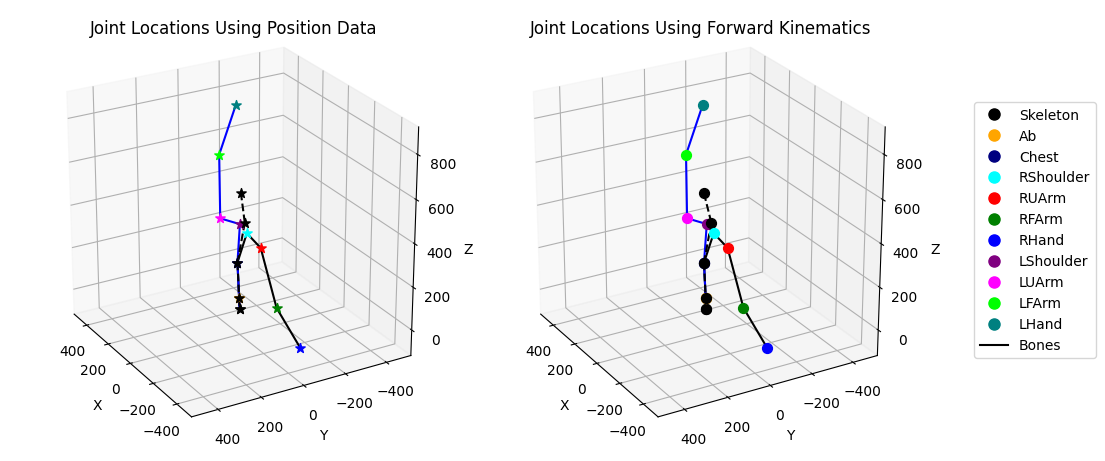

In [11]:
#%% Visualization of joint locations at time t
t = 1000
eul_seq = 'rzxy'

# Offset angle between strnm_dir_R/L and strnm_dir_H
strnm_dir_R = skl_R[('RShoulder', 'Position')] - skl_R[('Chest', 'Position')]
strnm_dir_L = skl_L[('LShoulder', 'Position')] - skl_L[('Chest', 'Position')]
strnm_dir_H = skl_H[('Neck', 'Position')] - skl_H[('Chest', 'Position')]
strnm_ang_R = np.arccos(np.dot(strnm_dir_R.iloc[t], strnm_dir_H.iloc[t])/(np.linalg.norm(strnm_dir_R.iloc[t])*np.linalg.norm(strnm_dir_H.iloc[t])))
strnm_ang_L = np.arccos(np.dot(strnm_dir_L.iloc[t], strnm_dir_H.iloc[t])/(np.linalg.norm(strnm_dir_L.iloc[t])*np.linalg.norm(strnm_dir_H.iloc[t])))

def get_positions(skl, chain):  
    positions = []
    for j in range(len(chain)):
        pos = skl[(chain[j], 'Position')].iloc[t]
        positions.append(np.array(pos))
    return positions - positions[0]

def get_euler(skl, chain):  
    eul = []
    R_prox = np.eye(3)
    for j in range(len(chain)):
        q = skl[(chain[j], 'Rotation')].iloc[t]
        R_global = quaternion_matrix(q)[:3,:3]
        R_rel = R_prox.T @ R_global
        R_prox = R_global
        eul_values = euler_from_matrix(R_rel, axes=eul_seq)
        # (ang1, ang2, ang3) = euler_from_matrix(R_rel, axes=eul_seq)
        # eul_values = np.array([ang1, ang2, ang3])
        eul.append(eul_values)
    return np.array(eul)

def forward_kinematics(skl, chain): 
    bone_pos = get_positions(skl, chain)
    bone_length = np.linalg.norm(np.diff(bone_pos, axis=0), axis=1)
    eul_angles = get_euler(skl, chain)
    
    fk_pose = np.zeros((len(eul_angles), 3))
    pos_prox = np.zeros(3)
    R_prox = np.eye(3)
    fk_pose[0] = bone_pos[0]
    for i in range(2):
        R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
        R_prox = R_prox @ R_rel
        pos_prox += R_prox @ np.array([0, 0, bone_length[i]])
        fk_pose[i+1] = pos_prox

    for i in range(2, len(eul_angles)-1):
        R_rel = euler_matrix(eul_angles[i, 0], eul_angles[i, 1], eul_angles[i, 2], axes=eul_seq)[:3, :3]
        R_prox = R_prox @ R_rel
        if chain==chain_R:  
            if i==2:
                R_off = euler_matrix(0, 0, strnm_ang_R, axes=eul_seq)[:3, :3]
                pos_prox += R_prox @ R_off @ np.array([0, 0, bone_length[i]])
            else:
                pos_prox += R_prox @ np.array([bone_length[i], 0, 0])
        elif chain==chain_L:
            if i==2:
                R_off = euler_matrix(0, 0, -strnm_ang_L, axes=eul_seq)[:3, :3]
                pos_prox += R_prox @ R_off @ np.array([0, 0, bone_length[i]])
            else:
                pos_prox += R_prox @ np.array([-bone_length[i], 0, 0])
        elif chain==chain_H:
            pos_prox += R_prox @ np.array([0, 0, bone_length[i]])
        fk_pose[i+1] = pos_prox
    return fk_pose

# Get bone positions from raw data
pos_raw_R = get_positions(skl_R, chain_R)
pos_raw_L = get_positions(skl_L, chain_L)
pos_raw_H = get_positions(skl_H, chain_H)

# Get bone positions using forward kinematics
pos_fk_R = forward_kinematics(skl_R, chain_R)
pos_fk_L = forward_kinematics(skl_L, chain_L)
pos_fk_H = forward_kinematics(skl_H, chain_H)

eul_angles_R = get_euler(skl_R, chain_R)
eul_angles_L = get_euler(skl_L, chain_L)
eul_angles_H = get_euler(skl_H, chain_H)

print("{:<10} {:<25} {:<25} {:<25}".format("pos_R:", "Raw", "FK", "Euler Angles"))
for j in range(len(chain_R)):
    print("{:<10} {:<25} {:<25} {:<25}".format(chain_R[j], str(np.around(pos_raw_R[j], 2)), str(np.around(pos_fk_R[j], 2)), str(np.around(eul_angles_R[j]*180/np.pi, 2))))
print("{:<10} {:<25} {:<25} {:<25}".format("pos_L:", "Raw", "FK", "Euler Angles"))
for j in range(len(chain_L)):
    print("{:<10} {:<25} {:<25} {:<25}".format(chain_L[j], str(np.around(pos_raw_L[j], 2)), str(np.around(pos_fk_L[j], 2)), str(np.around(eul_angles_L[j]*180/np.pi, 2))))        
for j in range(len(chain_H)):
    print("{:<10} {:<25} {:<25} {:<25}".format(chain_H[j], str(np.around(pos_raw_H[j], 2)), str(np.around(pos_fk_H[j], 2)), str(np.around(eul_angles_H[j]*180/np.pi, 2))))

# Plot positions using raw position data and forward kinematics
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(11, 4.5), constrained_layout=True, num='Joint Locations')
# fig.subplots_adjust(left=-0.5, wspace=0.08, right=1.2)
for ax in axes:
    ax.set(xlabel='X', ylabel='Y', zlabel='Z', xlim=(-500, 500), ylim=(-500, 500), zlim=(-100, 900))
    ax.view_init(elev=25, azim=150)
ax1, ax2 = axes[0], axes[1]
ax1.set_title('Joint Locations Using Position Data', pad=8)
ax2.set_title('Joint Locations Using Forward Kinematics', pad=8)
# colors = ['k', 'y', 'm', 'c', 'r', 'g', 'b']
colors_R = ['black', 'orange', 'navy', 'cyan', 'red', 'green', 'blue']
colors_L = ['black', 'orange', 'navy', 'purple', 'magenta', 'lime', 'teal']
for j in range(len(chain_R)):
    ax1.scatter(pos_raw_R[j][0], pos_raw_R[j][1], pos_raw_R[j][2], label=f"{chain_R[j]}, Raw", marker='*', s=50, color=colors_R[j])
    ax1.scatter(pos_raw_L[j][0], pos_raw_L[j][1], pos_raw_L[j][2], label=f"{chain_L[j]}, Raw", marker='*', s=50, color=colors_L[j])
    ax2.scatter(pos_fk_R[j][0], pos_fk_R[j][1], pos_fk_R[j][2], label=f"{chain_R[j]}, FK", marker='o', s=50, color=colors_R[j])
    ax2.scatter(pos_fk_L[j][0], pos_fk_L[j][1], pos_fk_L[j][2], label=f"{chain_L[j]}, FK", marker='o', s=50, color=colors_L[j])
    if j!=0:
        ax1.plot([pos_raw_R[j][0], pos_raw_R[j-1][0]], [pos_raw_R[j][1], pos_raw_R[j-1][1]], [pos_raw_R[j][2], pos_raw_R[j-1][2]], 'k')
        ax1.plot([pos_raw_L[j][0], pos_raw_L[j-1][0]], [pos_raw_L[j][1], pos_raw_L[j-1][1]], [pos_raw_L[j][2], pos_raw_L[j-1][2]], 'b')
        ax2.plot([pos_fk_R[j][0], pos_fk_R[j-1][0]], [pos_fk_R[j][1], pos_fk_R[j-1][1]], [pos_fk_R[j][2], pos_fk_R[j-1][2]], 'k')
        ax2.plot([pos_fk_L[j][0], pos_fk_L[j-1][0]], [pos_fk_L[j][1], pos_fk_L[j-1][1]], [pos_fk_L[j][2], pos_fk_L[j-1][2]], 'b')
for j in range(1, len(chain_H)):
    ax1.scatter(pos_raw_H[j][0], pos_raw_H[j][1], pos_raw_H[j][2], label=f"{chain_H[j]}, Raw", marker='*', s=50, color='black')
    ax2.scatter(pos_fk_H[j][0], pos_fk_H[j][1], pos_fk_H[j][2], label=f"{chain_H[j]}, FK", marker='o', s=50, color='black')
    if j!=0:
        ax1.plot([pos_raw_H[j][0], pos_raw_H[j-1][0]], [pos_raw_H[j][1], pos_raw_H[j-1][1]], [pos_raw_H[j][2], pos_raw_H[j-1][2]], 'k--')
        ax2.plot([pos_fk_H[j][0], pos_fk_H[j-1][0]], [pos_fk_H[j][1], pos_fk_H[j-1][1]], [pos_fk_H[j][2], pos_fk_H[j-1][2]], 'k--')
ax2.legend(handles=
    [Line2D([],[], color=colors_R[j], linestyle='', marker='o', markersize=8, label=f"{chain_R[j]}") for j in range(len(chain_R))] + 
    [Line2D([],[], color=colors_L[j], linestyle='', marker='o', markersize=8, label=f"{chain_L[j]}") for j in range(3, len(chain_L))] + 
    [Line2D([],[], color='black', linestyle='-', label='Bones')],  loc='right', bbox_to_anchor=(1.4, 0.5))
plt.show()
